# Projeto IA 1ªParte

#### THE_3_MUSKETEERS

###### Edith Cardoso - a22007545; Frederico Azevedo - a21900295; Nuno Rasteiro - a21906959;


### Library import


In [563]:
import csv as csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock

### Algoritmo de pesquisa informada num ambiente estático com obstáculos. 

### O objetivo será encontrar o caminho de menor custo desde o nó de partida até ao nó final.


Começamos por criar variaveis globais que vão conter os pesos de cada tipo de etiqueta no mapa.

Estes pesos são-nos dados na seguinte tabela.

<img src= "res/tabelaetiquetas.PNG">


In [564]:
CUSTO_T = 1
CUSTO_A = 3
CUSTO_F_B = 500  # Quando ve F ou B nao considera que é filho do nó

mapa_100x100 = 'sample-environment.csv'
mapa_15x15 = '15x15.csv'

Depois criámos uma função para ler o mapa de um csv para um dataframe usando o pandas.


In [565]:
# Importar dados do CSV para
def ler_csv(path):
    df = pd.read_csv(path)
    
    # drop first column
    df = df.iloc[:, 1:]
    return df



Agora temos o objetivo de converter este mapa, que temos num dataframe, para um dataset que contenha as ligações possiveis a partir de um nó chave, bem como o seu custo.

Para isso criámos funções que nos ajudam nos passos intermédios dessa conversão.


In [566]:
#Função para obter as cordenadas das etiquetas 'S' e 'E'
def retornar_cordenadas_inicio_fim(mapa):
    """
    Retorna as cordenadas de inicio do jogo e do fim do jogo.

    INPUT:
    dataframe   mapa
    """
    for linha in mapa:
        for coluna in mapa:
            temp_linha = int(linha)
            temp_coluna = int(coluna)
            if(mapa.loc[temp_linha][temp_coluna] == 'S'):
                cordenadas_inicio = f'{linha},{coluna}'

            if(mapa.loc[temp_linha][temp_coluna] == 'E'):
                cordenadas_fim = f'{linha},{coluna}'

    return cordenadas_inicio, cordenadas_fim


In [567]:
#Funções para calcular os custos 
def c(n):
    """
    Dada uma etiqueta 'n' retorna o seu custo
    
    INPUT:
    string   n
    """
    
    C = {
        'T': CUSTO_T,
        'A': CUSTO_A,
        'S': 0,
        'E': 0,
        'F': CUSTO_F_B,
        'B': CUSTO_F_B,
    }

    return C[n]

def calcula_custo(linha, coluna, mapa):
    """
    Calcula o custo de se movimentar para a posição (linha, coluna) no mapa.
    
    INPUT:
    int         linha
    int         coluna
    dataframe   mapa
    """
    
    return c(mapa.loc[int(linha)][int(coluna)])
    

In [568]:
# Funcao para calcular as oito direçoes possiveis de andar
def obtem_direcoes_possiveis(linha, coluna):
    """
    A partir de um par linha, coluna (posição atual) retorna uma lista com as oito posições possiveis de se movimentar

    INPUT:
    int         linha
    int         coluna
    """

    direcoes = [f'{max(linha-1,0)},{max(coluna-1,0)}',  # ↖
                f'{max(linha-1,0)},{coluna}',           # ↑
                f'{max(linha-1,0)},{min(coluna+1,99)}', # ↗
                f'{linha},{min(coluna+1,99)}',          # →
                f'{min(linha+1,99)},{min(coluna+1,99)}',# ↘
                f'{min(linha+1,99)},{coluna}',          # ↓
                f'{max(linha-1,0)},{max(coluna-1,0)}',  # ↙
                f'{min(linha+1,99)},{max(coluna-1,0)}', # ←
                f'{linha},{max(coluna-1,0)}']           # ↖

    return direcoes


In [569]:
# Funcao para criar dataset com os custos
def cria_dataset(mapa):
    """
    Cria um dataset em que a chave é uma posicao do mapa, e os valores são um dicionário do tipo { posição_filho : custo }

    INPUT:
    dataframe   mapa
    """
    df = dict()

    for linha in mapa:
        if int(linha) >= 0 and int(linha) < len(mapa)-1:
            for coluna in mapa:
                if int(coluna) >= 0 and int(coluna) < len(mapa.columns) -1:
                    key = f'{linha},{coluna}'
                    temp_linha = int(linha)
                    temp_coluna = int(coluna)

                    direcoes = obtem_direcoes_possiveis(
                        temp_linha, temp_coluna)

                    for i in range(len(direcoes)):
                        temp_linha, temp_coluna = direcoes[i].split(',')
                        if mapa.loc[int(temp_linha)][int(temp_coluna)] != 'F' and mapa.loc[int(temp_linha)][int(temp_coluna)] != 'B':
                            current_key = str(temp_linha) + \
                                ',' + str(temp_coluna)
                            custo = c(mapa.loc[int(temp_linha)][int(temp_coluna)])
                            if key not in df:
                                df[key] = ({current_key: custo})
                            else:
                                df[key].update({current_key: custo})

    return df


Optamos por usar o algoritmo A* para solucionar este problema.

In [570]:
def a_star_algorithm(lista_de_adjacencia, start_node, stop_node, mapa):
    # open_list is a list of nodes which have been visited, but who's neighbors
    # haven't all been inspected, starts off with the start node
    # closed_list is a list of nodes which have been visited
    # and who's neighbors have been inspected
    open_list = set([start_node])
    closed_list = set([])

    cf1, cf2 = stop_node.split(',')

    # g contains current distances from start_node to all other nodes
    # the default value (if it's not found in the map) is +infinity
    g = {}

    g[start_node] = 0

    # parents contains an adjacency map of all nodes
    parents = {}
    parents[start_node] = start_node

    while len(open_list) > 0:
        n = None

        # find a node with the lowest value of f() - evaluation function
        for v in open_list:
            cord1, cord2 = v.split(",")
            #aux = mapa.loc[int(cord1)][int(cord2)]
            #if n == None or g[v] + h(int(cord1),int(cord2),stop_node,c(aux)) < g[n] + h(int(cord1),int(cord2),stop_node,c(aux)):
            #if n == None or g[v] + cityblock([int(cord1),int(cord2)],[int(cf1), int(cf2)]) < g[n] + cityblock([int(cord1),int(cord2)],[int(cf1), int(cf2)]) :
            if n == None or g[v] + cityblock([int(cord1), int(cord2)], [int(cf1), int(cf2)]) < g[n] + cityblock([int(cord1), int(cord2)], [int(cf1), int(cf2)]):
                n = v
            
        if n == None:
            print('Não existe caminho!')
            return None

        # if the current node is the stop_node
        # then we begin reconstructin the path from it to the start_node
        if n == stop_node:
            reconst_path = []

            while parents[n] != n:
                reconst_path.append(n)
                n = parents[n]

            reconst_path.append(start_node)
            reconst_path.reverse()
            custo = calcula_custo_caminho(reconst_path, mapa)

            return reconst_path, open_list, closed_list , custo

        # for all neighbors of the current node do
        for m in lista_de_adjacencia[f"{n}"]:
            weight = lista_de_adjacencia[f"{n}"].get(f"{m}")
            # if the current node isn't in both open_list and closed_list
            # add it to open_list and note n as it's parent
            if m not in open_list and m not in closed_list:
                open_list.add(m)
                parents[m] = n
                g[m] = g[n] + weight

            # otherwise, check if it's quicker to first visit n, then m
            # and if it is, update parent data and g data
            # and if the node was in the closed_list, move it to open_list
            else:
                if g[m] > g[n] + weight:
                    g[m] = g[n] + weight
                    parents[m] = n

                    if m in closed_list:
                        closed_list.remove(m)
                        open_list.add(m)

        # remove n from the open_list, and add it to closed_list
        # because all of his neighbors were inspected
        open_list.remove(n)
        closed_list.add(n)

    print('Path does not exist!')
    return None


Depois de obtermos o caminho resultante do A* usamos as seguintes funções para calcular e mostrar os resultados

In [571]:
#Função para calcular o custo do caminho resultante do A*
def calcula_custo_caminho(caminho, mapa):
    """
    Calcula o custo total de um caminho.

    INPUT:
    list        caminho
    dataframe   mapa
    """
    
    custo = 0
    for node in caminho:
        cord1, cord2 = node.split(',')
        custo += c(mapa.loc[int(cord1)][int(cord2)])
    return custo

In [572]:
#Função para construir um mapa para ser impresso como heatmap, por questoes de visualização :)
def constroi_mapa_final(mapa, visitados, caminho):
    """
    Constroi o dataframe do mapa final, substitui os nós visitados pela etiqueta 'V' e os nós do menor caminho pela etiqueta 'SP'.

    INPUT:
    dataframe   mapa
    list        visitados
    list        caminho
    """

    mapa_final = mapa.copy(deep=True)
    if visitados != None:
        for node in visitados:
            cord1, cord2 = node.split(",")
            mapa_final.loc[int(cord1)][int(cord2)] = 'V'

    for node in caminho:
        cord1, cord2 = node.split(",")
        mapa_final.loc[int(cord1)][int(cord2)] = 'SP'

    return mapa_final

In [573]:
#Função para exportar o mapa resultado para csv
def exporta_df_csv(df):
    """
    Exporta um dataframe para csv.
    
    INPUT:
    dataframe   df
    """
    df.to_csv('final.csv', encoding='utf-8', index=False)

In [574]:
#Função para gerar o heatmap do mapa
def df_to_heatmap(mapa):
    """
    Converte um dataframe para um heatmap, e imprime-o no ecrã.
    
    INPUT:
    dataframe   mapa
    """
    
    aux_mapa = mapa.copy(deep=True)
    aux_mapa = aux_mapa.replace(['SP'],10)
    aux_mapa = aux_mapa.replace(['V'],6)
    aux_mapa = aux_mapa.replace(['A'],-10)
    aux_mapa = aux_mapa.replace(['T'],2)
    aux_mapa = aux_mapa.replace(['S'],0)
    aux_mapa = aux_mapa.replace(['E'],0)
    aux_mapa = aux_mapa.replace(['F'],15)
    aux_mapa = aux_mapa.replace(['B'],15)
    
    sns.heatmap(aux_mapa, square=True, center=0, yticklabels=False, xticklabels=False)
    plt.show()

    

#### Função Principal

In [575]:
class Game():
    def __init__(self):
        self.run_game()

    def run_game(self):
        mapa = ler_csv(mapa_100x100)
        dataset = cria_dataset(mapa)
        print(" == Mapa Inicial ==")
        df_to_heatmap(mapa)

        coordenadas = retornar_cordenadas_inicio_fim(mapa)
        caminho, open_list, closed_list, custo = a_star_algorithm(dataset,coordenadas[0],coordenadas[1], mapa)
        mapa_final = constroi_mapa_final(mapa, closed_list, caminho)
        print(f"Caminho encontrado!\n{caminho}\nCusto = \033[1;32m{custo}\u001b[0m\nCaminho passa por \033[1;32m{len(caminho)}\u001b[0m nós.\nForam visitados \033[1;32m{len(closed_list)}\u001b[0m nós.\n")
        print("== Mapa Final ==\n\033[1;32mLaranja -> Percorrido\nVermelho -> Visitado")
        df_to_heatmap(mapa_final)
        df_to_heatmap(constroi_mapa_final(mapa, None, caminho))
        exporta_df_csv(mapa_final)


 == Mapa Inicial ==


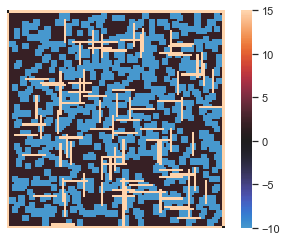

Caminho encontrado!
['0,0', '1,1', '2,2', '3,3', '4,4', '5,5', '6,4', '7,5', '8,6', '9,6', '10,6', '11,6', '12,7', '13,8', '14,9', '15,10', '16,11', '17,10', '18,11', '19,12', '20,12', '21,13', '22,14', '21,15', '20,16', '19,17', '18,18', '19,19', '20,20', '20,21', '19,22', '19,23', '19,24', '19,25', '19,26', '20,27', '21,28', '22,29', '23,30', '24,31', '24,32', '25,33', '26,34', '26,35', '27,36', '28,36', '29,37', '30,36', '31,37', '32,38', '33,39', '34,40', '34,41', '35,42', '35,43', '35,44', '34,45', '33,46', '33,47', '32,48', '31,49', '31,50', '30,51', '30,52', '31,53', '31,54', '32,55', '33,56', '34,57', '35,58', '36,59', '36,60', '37,61', '38,62', '39,63', '40,64', '41,65', '42,66', '43,67', '44,68', '45,68', '46,69', '47,70', '48,71', '48,72', '49,73', '50,74', '50,75', '51,76', '52,77', '53,78', '54,77', '55,76', '56,77', '57,78', '58,78', '59,79', '60,79', '61,80', '62,79', '63,79', '64,80', '65,79', '66,80', '67,81', '68,82', '69,83', '70,83', '71,84', '71,85', '71,86', '71,8

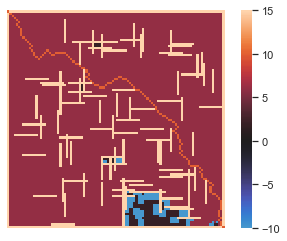

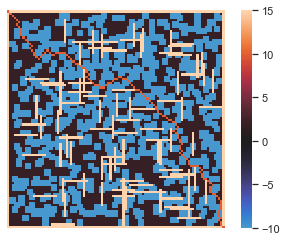

In [576]:
def main():
    g = Game()


if __name__ == "__main__":
    main()
